# Mixup

Mixup implementation and visualization

In [1]:
from collections import OrderedDict
from copy import deepcopy
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from joblib import Parallel, delayed
import sklearn
import sklearn.datasets as datasets
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F

/opt/anaconda3/envs/py310/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Data

In [2]:
def mixup(X, y, alpha=0.2, n_mix=None, seed=None):
	'''
	Mixup data augmentation method.

	Parameters
	----------
	X : array-like, shape (n_samples, n_features)
		The data to be augmented.
	y : array-like, shape (n_samples,)
		The target values to be augmented.
	alpha : float, default=0.2
		The mixing parameter.
	n_mix : int, default=None
		The number of samples to mix with. If None, it is set to the number of
	seed : int or None, default=None
		The seed used by the random number generator.

	Returns
	-------
	X_mix : array-like, shape (n_samples, n_features)
		The mixed data.

	y_mix : array-like, shape (n_samples,)
		The mixed target values.
	'''
	if seed is not None:
		rng = np.random.RandomState(seed)
	else:
		rng = np.random.RandomState()

	n_samples = len(X)
	lam = torch.from_numpy(rng.beta(alpha, alpha, size=(n_mix, 1))).float()
	replace = True
	perm1 = rng.choice(n_samples, size=n_mix, replace=replace)
	perm2 = rng.choice(n_samples, size=n_mix, replace=replace)
	X1, X2 = X[perm1], X[perm2]
	y1, y2 = y[perm1], y[perm2]
	X_mix = lam * X1 + (1 - lam) * X2
	y_mix = lam * y1 + (1 - lam) * y2
	return X_mix, y_mix
	
def onehot(y):
	'''
	One-hot encoding of the target values.

	Parameters
	----------
	y : array-like, shape (n_samples,)
		The target values.

	Returns
	-------
	y_onehot : array-like, shape (n_samples, n_classes)
		The one-hot encoded target values.
	'''
	y_onehot = np.zeros((y.shape[0], y.max() + 1))
	y_onehot[np.arange(y.shape[0]), y] = 1
	return y_onehot

seed = 0
n_mix = 1000
alpha = 0.1
n_samples = 1000
n_features = 2
n_classes = 2
test_size = 0.9

np.random.seed(seed)

# X, y = datasets.make_classification(n_samples=n_samples, n_features=n_features, n_redundant=0, n_informative=2, n_clusters_per_class=1, n_classes=n_classes, random_state=seed)

X, y = datasets.make_circles(n_samples=n_samples, noise=0.3, factor=0.5, random_state=seed)

y = onehot(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)

X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()
X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()

### Models

In [3]:
class LogitReg(nn.Module):
	def __init__(self, n_features):
		super(LogitReg, self).__init__()
		self.linear = nn.Linear(n_features, 2)

	def forward(self, x):
		x = self.linear(x)
		return x

def get_models():
	'''Re-initializes the models.'''
	mlp_h_sizes = [n_features, 10, 10, n_classes]
	mlp_layers = {}
	for i in range(len(mlp_h_sizes) - 1):
		mlp_layers[f'layer_{i}'] = nn.Linear(mlp_h_sizes[i], mlp_h_sizes[i+1])
		if i < len(mlp_h_sizes) - 2:
			mlp_layers[f'act_fn_{i}'] = nn.ReLU()
	mlp_mix_a01 = nn.Sequential(OrderedDict(mlp_layers))
	mlp_mix_a02 = nn.Sequential(OrderedDict(mlp_layers))
	mlp_no_mix = deepcopy(mlp_mix_a01)
	log_reg = LogitReg(n_features)
	models = [
		(
			'mlp_mix_a01', mlp_mix_a01, torch.optim.SGD(mlp_mix_a01.parameters(), lr=0.01),
			*mixup(X_train, y_train, alpha=0.1, n_mix=n_mix, seed=seed)
		),
		(
			'mlp_mix_a02', mlp_mix_a02, torch.optim.SGD(mlp_mix_a02.parameters(), lr=0.01),
			*mixup(X_train, y_train, alpha=0.2, n_mix=n_mix, seed=seed)
		),
		(
			'mlp_no_mix', mlp_no_mix, torch.optim.SGD(mlp_no_mix.parameters(), lr=0.01), X_train, y_train
		),
		(
			'logit_reg', log_reg, torch.optim.SGD(log_reg.parameters(), lr=0.01), X_train, y_train
		)
	]
	return models

### Train and test

In [4]:
def train_model(model, opt, X_train, y_train, n_epochs, batch_size=32):
	model.train()
	for epoch in range(n_epochs):
		for i in range(0, X_train.shape[0], batch_size):
			X_batch = X_train[i:i+batch_size]
			y_batch = y_train[i:i+batch_size]
			y_pred = model(X_batch)
			loss = F.binary_cross_entropy_with_logits(y_pred, y_batch)
			opt.zero_grad()
			loss.backward()
			opt.step()
	return model.eval()

def test_model(model, X_test, y_test, scorer=accuracy_score):
	model.eval()
	y_pred = model(X_test).detach().numpy()
	y_pred_label = y_pred.argmax(axis=1)
	y_test_label = y_test.detach().numpy().argmax(axis=1)
	return scorer(y_test_label, y_pred_label)

def train_and_test(X_test, y_test, n_iter, scorer=accuracy_score):
	'''
	Re-init, train and test the models. Return the scores for each model each iteration.

	Parameters
	----------
	X_test : torch.Tensor
		The test data.
	y_test : torch.Tensor
		The test labels.
	n_iter : int
		The number of iterations.
	scorer : function
		The scoring function.

	Returns
	-------
	scores : np.array
	'''
	models = get_models()
	scores = []
	for iter in range(n_iter):
		epoch_scores = []
		for model_name, model, opt, X_train_model, y_train_model in models:
			if 'no_mix' in model_name:
				batch_size = X_train_model.shape[0]
				n_epochs = 100 * n_mix
			else:
				batch_size = 32
				n_epochs = 100
			train_model(model, opt, X_train_model, y_train_model, n_epochs=n_epochs, batch_size=batch_size)
			acc = test_model(model, X_test, y_test, scorer)
			epoch_scores.append(acc)
		scores.append(epoch_scores)
	trained_models = [(model_name, model) for model_name, model, _, _, _ in models]
	return np.array(scores), trained_models

### Run simulations

In [5]:
n_sims = 5
n_iter = 10
sim_res = Parallel(n_jobs=-1)(delayed(train_and_test)(X_test, y_test, n_iter=n_iter) for _ in range(n_sims))

In [6]:
scores = []
trained_models = []
for sim_res_i in sim_res:
	scores.append(sim_res_i[0])
	trained_models.append(sim_res_i[1])
scores = np.array(scores)
trained_models = np.array(trained_models, dtype=object)
best_iter_ix = np.argmax(scores[:,-1,:], axis=0)
best_models = trained_models[best_iter_ix, np.arange(trained_models.shape[1])]

### Visualize

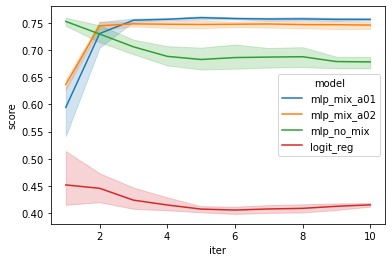

In [7]:
plot_df = []
for mi, (model_name, model) in enumerate(best_models):
	for si in range(n_sims):
		for ii in range(n_iter):
			plot_df.append([model_name, ii + 1, scores[si,ii,mi]])
plot_df = pd.DataFrame(plot_df, columns=['model', 'iter', 'score'])

sns.lineplot(x='iter', y='score', hue='model', data=plot_df)
plt.show()

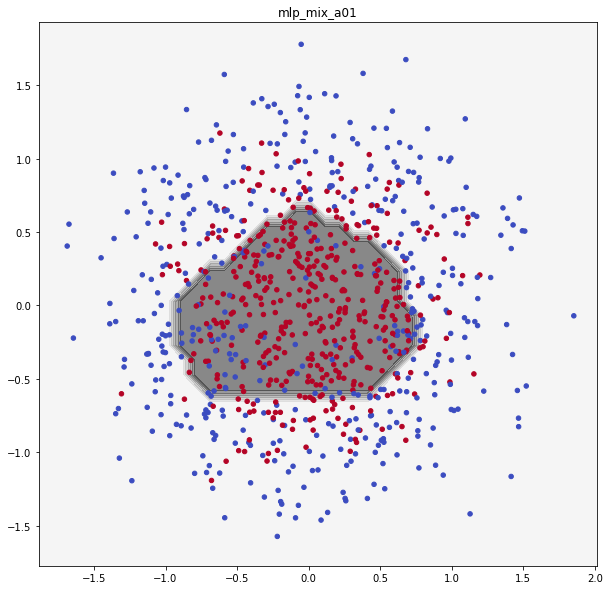

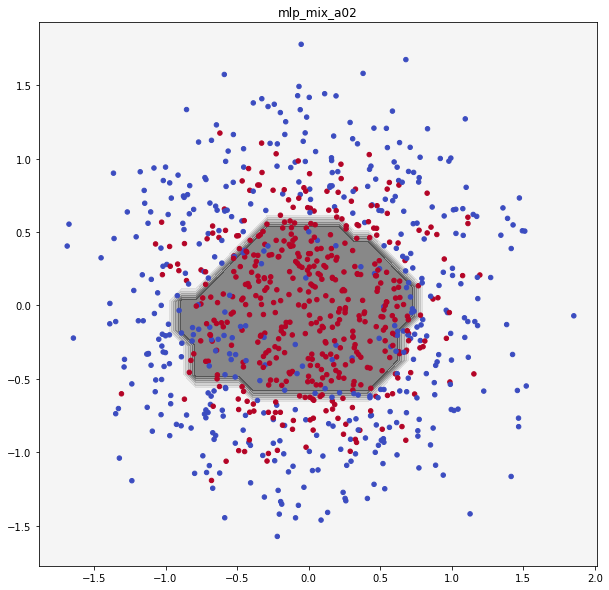

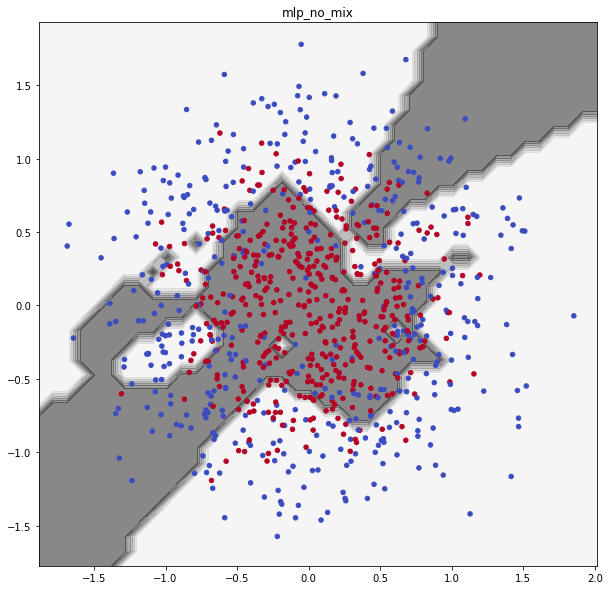

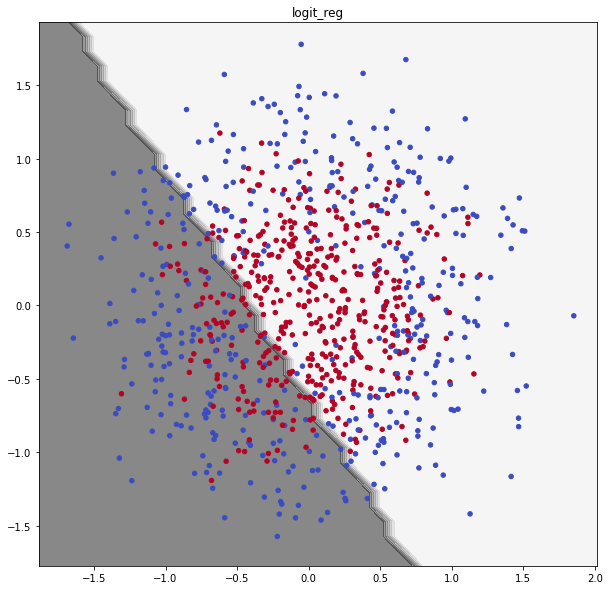

In [8]:
# Decision boundary
x_min, x_max = X_test[:, 0].min() - 0.2, X_test[:, 0].max() + 0.2
y_min, y_max = X_test[:, 1].min() - 0.2, X_test[:, 1].max() + 0.2
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))

for model_name, model in best_models:
	model.eval()
	Z = model(torch.from_numpy(np.c_[xx.ravel(), yy.ravel()]).float()).detach().numpy().argmax(axis=1)

	Z = Z.reshape(xx.shape)

	plt.figure(figsize=(10, 10))
	plt.contourf(xx, yy, Z, cmap=plt.cm.binary, alpha=0.5)
	plt.scatter(X_test[:, 0], X_test[:, 1], cmap=plt.cm.coolwarm, c=y_test[:, 1].numpy(), marker='o', s=20)
	plt.title(f'{model_name}')
	plt.show()

### Mixup augmented data visualization

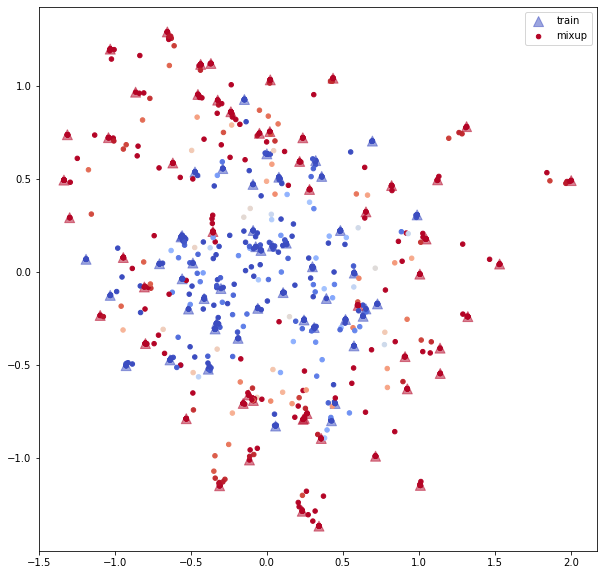

In [9]:
plt.figure(figsize=(10, 10))
plt.scatter(X_train[:, 0], X_train[:, 1], cmap=plt.cm.coolwarm, c=y_train[:, 0].numpy(), marker='^', s=100, label='train', alpha=0.5)
X_mix, y_mix = mixup(X_train, y_train, alpha=0.1, n_mix=n_mix, seed=seed)
plt.scatter(X_mix[:, 0], X_mix[:, 1], cmap=plt.cm.coolwarm, c=y_mix[:, 0].numpy(), marker='o', s=20, label='mixup')
plt.legend()
plt.show()